<a href="https://colab.research.google.com/github/iamkarthikbk/ee5333-2025/blob/main/mywork/tut2-31jan/Partition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pygit2 1.17.0 requires cffi>=1.17.0, but you have cffi 1.15.1 which is incompatible.


## Partitioning

* Kernighan Lin Algorithm for bi-partitioning ($V'$) :
  + $G=(V,E)$
  + $A$, $B$ $\subset V$
  + $A \cup B = V$
  + $A\cap B = ∅$
  + $|A| = |B| = \dfrac{|V|}{2}$
  + Flowchart:

    <img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/part/fig/KL_flowchart.jpg" width=698 height=612 />


In [16]:
# [karthik] Vertex class represents a node in the graph for Kernighan-Lin partitioning algorithm
## Each vertex maintains information about its partition assignment and connectivity
class Vertex:
  def __init__(self, i, part):
    ## Unique identifier for the vertex
    self._id = i
    ## List of neighboring vertices (adjacency list)
    self._nbrs = []
    ## Current partition assignment (0 for partition A, 1 for partition B)
    self._part = part
    ## Number of edges connecting to vertices in partition A (external cost to A)
    self._ea = 0
    ## Number of edges connecting to vertices in partition B (external cost to B)
    self._eb = 0
    ## D value represents the gain from moving vertex to opposite partition
    ## For vertices in A: D = EB - EA
    ## For vertices in B: D = EA - EB
    self._d  = 0

  ## Reset vertex properties when starting a new iteration
  def reset(self, part):
    ## Reset partition assignment and clear all costs/gains
    (self._part, self._ea, self._eb, self._d) = (part, 0, 0, 0)

  ## String representation for debugging and visualization
  def __str__(self):
    return '(' + str(self._id) + ',' + str(self._part) + ',' + str(self._ea) + ',' + str(self._eb) + ',' + str(self._d) + ',' + str([i._id for i in self._nbrs]) + ')'

  ## Representation method returns the same as string method
  def __repr__(self):
    return str(self)

# clear the partition, EA, EB and D values
# do this at the beginning of every iteration
## [karthik] Function to initialize/reset the partition assignments and compute costs
## Parameters:
##   V: List of all vertices in the graph
##   A: Set of vertex indices in partition A
##   B: Set of vertex indices in partition B
def reset(V, A, B):
  ## Phase 1: Reset partition assignments
  ## Iterate through both partitions (j=0 for A, j=1 for B)
  ## NOTE: Looks like this is hard-coded for 2 partitions.
  for j in range(2):
    partition = A if (0 == j) else B
    ## Assign vertices to their respective partitions and clear their costs
    for i in partition:
      V[i].reset(j)

  ## Phase 2: Compute external costs (EA and EB)
  ## For each vertex, count number of neighbors in each partition
  for v in V:
    ## Verify vertex is properly assigned to either partition A(0) or B(1)
    assert(v._part == 0 or v._part == 1)
    ## Count neighbors in each partition
    for n in v._nbrs:
      if n._part == 0:
        ## Increment EA if neighbor is in partition A
        v._ea += 1
      else:
        ## Increment EB if neighbor is in partition B
        v._eb += 1

  ## Phase 3: Compute D values (gains)
  ## D = EB-EA for vertices in A
  ## D = EA-EB for vertices in B
  for v in V:
    v._d = (v._ea - v._eb) if (v._part == 1) else (v._eb - v._ea)

# [karthik] Find the pair of vertices whose swap will result in maximum reduction in cut size
## Parameters:
##   V: List of all vertices in the graph
##   Ap: Set of unlocked vertices in partition A that can be swapped
##   Bp: Set of unlocked vertices in partition B that can be swapped
##   E: Set of edges in the graph, each edge is represented as (min_vertex, max_vertex)
def findMaxGain(V, Ap, Bp, E):
  ## Initialize maximum gain tracking variables
  ## amax: vertex from partition A that gives max gain
  ## bmax: vertex from partition B that gives max gain
  ## gmax: maximum gain value found so far
  ## Initial gmax is set to less than minimum possible gain (-2|E|-1)
  (amax, bmax, gmax) = (-1, -1, -2 * len(E) - 1)

  ## Try all possible pairs of vertices from Ap and Bp
  for a in Ap:
    for b in Bp:
      ## Calculate gain from swapping vertices a and b:
      ## 1. Add D values of both vertices (external costs difference)
      ## 2. Subtract 2 if vertices are connected (edge rearrangement cost)
      ##    - If a-b edge exists, it moves from cut to uncut or vice versa
      ##    - This changes the cut size by 2 in the opposite direction
      g = V[a]._d + V[b]._d - (2 if (min(a,b), max(a,b)) in E else 0)

      ## Update maximum gain if current gain is better
      if gmax < g:
        (amax, bmax, gmax) = (a, b, g)

  ## Verify that we found a valid pair to swap
  ## This should never fail unless the input sets are empty
  assert(amax >= 0 and bmax >= 0)
  return (amax, bmax, gmax)

# update the E and D for only the affected neighbours of a and b
def updateED(V, a, b):
  V[a]._part = 1
  V[b]._part = 0
  for i in [a,b]:
    for n in V[i]._nbrs:
      if i == a:
        n._ea -= 1
        n._eb += 1
      else:
        n._ea += 1
        n._eb -= 1
      n._d = (n._ea - n._eb) if (n._part == 1) else (n._eb - n._ea)

# [karthik] Implementation of Kernighan-Lin graph partitioning algorithm
## This algorithm tries to split a graph into two equal-sized parts while minimizing
## the number of edges that cross between the parts (cut edges)
##
## Parameters:
##   N: Number of vertices in the graph (labeled from 0 to N-1)
##   E: List of edges, where each edge is a pair of vertex numbers, unordered.
## Returns:
##   A: Set of vertices in partition A
##   B: Set of vertices in partition B
##   cut: Number of edges crossing between partitions
def KLPart(N, E):
  ## Handle odd number of vertices by adding a dummy vertex
  if N%2: N+= 1 # make N even if its odd by adding a single no-neighbour vertex

  ## Create vertex objects and build the graph structure
  ## Initialize all vertices with partition = -1 (unassigned)
  V = [Vertex(i, -1) for i in range(N)]

  ## Normalize edge representation: always store edges as (smaller_vertex, larger_vertex)
  for e in E:
    if e[0] > e[1]: e = (e[1], e[0])
    else: e = (e[0], e[1])

  ## Convert to set for two purposes:
  ## 1. Remove any duplicate edges from input
  ## 2. Enable O(1) edge existence checking through hash table lookup
  ##    - Python sets are implemented as hash tables
  ##    - Each edge tuple is hashed to a specific bucket
  ##    - Looking up an edge only requires computing its hash and checking that bucket
  E = set(E)

  ## Build adjacency lists: for each edge, add vertices to each other's neighbor lists
  for e in E:
    V[e[0]]._nbrs.append(V[e[1]])
    V[e[1]]._nbrs.append(V[e[0]])

  ## Initial random partitioning
  import random
  Vc = V[:]  ## Make a copy of vertex list for shuffling
  partLen = N//2  ## Size of each partition
  random.shuffle(Vc)  ## Randomly order vertices

  ## Create initial partitions A and B with equal sizes
  A = {Vc[i]._id for i in range(partLen)}         ## First half goes to A
  B = {Vc[i]._id for i in range(partLen, N)}      ## Second half goes to B

  print(A)  ## Debug: show initial partition A
  print(B)  ## Debug: show initial partition B

  ## Main Kernighan-Lin loop
  maxGain = 1  ## Initialize with positive gain to enter loop
  while maxGain >= 0:
    ## Make copies of partitions for this iteration
    Ap, Bp = A.copy(), B.copy()

    ## Initialize vertex properties (EA, EB, D values)
    reset(V, A, B)

    ## Lists to track gains and swaps
    G = []  ## Gains from each swap
    S = []  ## Pairs of vertices that were swapped

    ## Find and store best pairs to swap
    for p in range(partLen):
      ## Find best pair to swap from remaining vertices
      (a, b, g) = findMaxGain(V, Ap, Bp, E)

      ## Update vertex properties after theoretical swap
      updateED(V, a, b)

      ## Remove chosen vertices from consideration
      Ap.remove(a)
      Bp.remove(b)

      ## Store gain and vertex pair
      G.append(g)
      S.append((a, b))

    ## Calculate cumulative gains
    for i in range(1, len(G)):
      G[i] += G[i-1]

    ## Find point of maximum cumulative gain
    maxGain = max(G)
    maxIndex = G.index(maxGain)

    ## If we found a sequence of swaps that improves the cut
    if maxGain > 0:
      ## Actually perform the swaps up to the point of maximum gain
      for (a, b) in S[0:maxIndex + 1]:
        A.remove(a)
        B.remove(b)
        A.add(b)
        B.add(a)
    else:
      break  ## No improvement possible, exit main loop

  ## Count the final number of edges that cross between partitions A and B
  ## A cut edge is one that has one endpoint in A and one in B
  cut = 0
  ## Check every possible pair of vertices (a,b) where:
  ## - a is from partition A
  ## - b is from partition B
  for a in A:
    for b in B:
      ## Check if this pair of vertices forms an edge in our graph
      ## We normalize the edge representation (smaller vertex first)
      ## to match how edges are stored in set E
      if (min(a, b), max(a,b)) in E:
        cut += 1  ## Found a cut edge, increment counter
  ## Return final partitions and the number of edges between them
  return (A, B, cut)

In [17]:
print(KLPart(8, [(0,1), (0,4), (0,5), (1,4), (1,5), (4,5), (2,3), (2,6), (2,7), (3,6), (3,7), (6,7), (2,5)]))

{0, 3, 6, 7}
{1, 2, 4, 5}
({2, 3, 6, 7}, {0, 1, 4, 5}, 1)


## Bipartitioning using ILP
+ $x_v$ is the indicator variable for $v$ being in $A$
+ $x_{u,v}$ is the indicator variable for $(u,v)\in E$ being cut
+ <ul>
$\begin{align}
        x_{u,v} = x_u \oplus x_v
\end{align}$
</ul>

+ Objective: $\min\limits_{x_v, x_{u,v}} \sum\limits_{(u,v)\in E}x_{u,v}$
+ Subject to constraints:
<ul>
$\begin{align}
\sum_{v\in V} x_v&=\frac{|V|}{2}\\
x_u - x_v &\leq x_{u,v}, &\forall (u,v) \in E\\
x_v - x_u &\leq x_{u,v}, &\forall (u,v) \in E\\
x_u + x_v &\geq x_{u,v}, &\forall (u,v) \in E\\
x_u + x_v + x_{u,v} &\leq 2, &\forall (u,v) \in E\\
x_v &\in \{0, 1\}, &\forall v \in V\\
x_{u,v} &\in \{0, 1\}, &\forall (u,v) \in E
\end{align}$
</ul>


In [4]:
## [karthik] Solve graph bipartitioning using Integer Linear Programming (ILP)
def bipartition(N, E):
  import mip
  ## Create a new ILP model
  model = mip.Model("Bi-partition")

  ## Create binary decision variables:
  ## x[v] = 1 if vertex v is in partition A, 0 if in B
  x = [model.add_var(f"x_{u}", var_type = mip.BINARY) for u in range(N)]

  ## x_uv[e] = 1 if edge e is cut (endpoints in different partitions), 0 otherwise
  x_uv = [model.add_var(f"x_{u}_{v}", var_type = mip.BINARY) for u,v in E]
  model.verbose = 0

  ## Objective: Minimize the number of cut edges (sum of x_uv variables)
  model.objective = mip.minimize(mip.xsum(x_uv))

  ## Constraint: Equal partition sizes (sum of x[v] = N/2)
  model += (mip.xsum(x) == N//2)

  ## Add XOR constraints for each edge
  ## These four inequalities together enforce x_uv = x[u] XOR x[v]
  for e, (u,v) in enumerate(E):
    ## If vertices are in different partitions (|x[u] - x[v]| = 1),
    ## then edge must be cut (x_uv[e] = 1)
    model += (x[u] - x[v] <= x_uv[e])    # If x[u]=1, x[v]=0, then x_uv[e] must be 1
    model += (x[v] - x[u] <= x_uv[e])    # If x[u]=0, x[v]=1, then x_uv[e] must be 1
    model += (x[u] + x[v] >= x_uv[e])    # If x[u]=x[v]=0, then x_uv[e] must be 0
    model += (x[u] + x[v] + x_uv[e] <= 2) # If x[u]=x[v]=1, then x_uv[e] must be 0

  ## Save the model to a file (for debugging)
  model.write("bipartition.lp")

  ## Solve the ILP
  model.optimize()

  ## If optimal solution found, construct and return the partitions
  if model.status == mip.OptimizationStatus.OPTIMAL:
    ## Vertices with x[v] ≈ 1 go to partition A
    ## Using 0.9 threshold to handle numerical precision issues
    A = [i for i in range(N) if x[i].x >= 0.9]
    ## Remaining vertices go to partition B
    B = [i for i in range(N) if x[i].x < 0.9]
    ## Return partitions and number of cut edges
    return (A, B, model.objective.x)
  return None

In [5]:
print(bipartition(8, [(0,1), (0,4), (0,5), (1,4), (1,5), (4,5), (2,3), (2,6), (2,7), (3,6), (3,7), (6,7), (2,5)]))

([2, 3, 6, 7], [0, 1, 4, 5], 1.0)


In [6]:
def random_graph(N, fns):
  import networkx as nx
  import time
  ## Create a random Erdős-Rényi graph with N vertices
  ## In an Erdős-Rényi graph G(n,p):
  ##   - Each possible edge between n vertices exists with probability p
  ##   - Edges are added independently of each other
  ##   - Expected number of edges = p * (n choose 2)
  ##   - Here: n=N vertices, p=0.4 (40% chance for each edge)
  g = nx.erdos_renyi_graph(N, 0.4)
  G = []  ## List to store visualizations for each partitioning method

  ## Test each partitioning function
  for fn in fns:
    ## Measure runtime of partitioning
    t = time.time()
    result = fn(N, g.edges)
    if result is None:
        print(f"Function {fn.__name__} returned None.")
    (A,B,c) = result
    print("runtime : ", time.time() - t, 'cut size : ', c)

    ## Create visualization using graphviz
    import graphviz
    gv = graphviz.Graph()

    ## Convert sets to lists for iteration
    A = list(A)
    B = list(B)

    ## Add nodes for partition A (colored red)
    for i in range(len(A)):
      gv.node(str(A[i]), color='red', shape='circle')

    ## Add nodes for partition B (colored blue)
    for i in range(len(B)):
      gv.node(str(B[i]), color='blue', shape='circle')

    ## Add all edges to the visualization
    for e in g.edges:
      gv.edge(str(e[0]), str(e[1]), splines='line')

    #gv.engine = 'patchwork'  ## Alternative layout engine (commented out)
    G.append(gv)  ## Store this visualization

  return G  ## Return list of visualizations

{4, 5, 7, 8, 9}
{0, 1, 2, 3, 6}
runtime :  0.0003204345703125 cut size :  8
runtime :  0.5308988094329834 cut size :  8.0


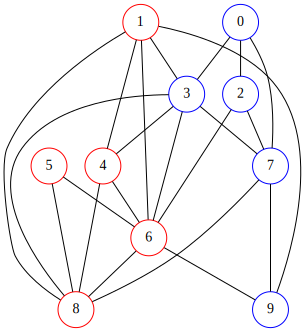

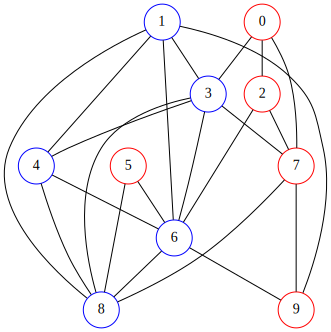

In [7]:
G = random_graph(10, [KLPart, bipartition])
from IPython.display import display
display(G[0], G[1])

In [8]:
!cat bipartition.lp

\Problem name: Bi-partition

Minimize
OBJROW: x_0_2 + x_0_3 + x_0_7 + x_1_3 + x_1_4 + x_1_6 + x_1_8 + x_1_9 + x_2_6 + x_2_7
 + x_3_4 + x_3_6 + x_3_7 + x_3_8 + x_4_6 + x_4_8 + x_5_6 + x_5_8 + x_6_8 + x_6_9
 + x_7_8 + x_7_9
Subject To
constr(0):  x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9
 = 5
constr(1):  x_0 - x_2 - x_0_2 <= -0
constr(2):  - x_0 + x_2 - x_0_2 <= -0
constr(3):  x_0 + x_2 - x_0_2 >= -0
constr(4):  x_0 + x_2 + x_0_2 <= 2
constr(5):  x_0 - x_3 - x_0_3 <= -0
constr(6):  - x_0 + x_3 - x_0_3 <= -0
constr(7):  x_0 + x_3 - x_0_3 >= -0
constr(8):  x_0 + x_3 + x_0_3 <= 2
constr(9):  x_0 - x_7 - x_0_7 <= -0
constr(10):  - x_0 + x_7 - x_0_7 <= -0
constr(11):  x_0 + x_7 - x_0_7 >= -0
constr(12):  x_0 + x_7 + x_0_7 <= 2
constr(13):  x_1 - x_3 - x_1_3 <= -0
constr(14):  - x_1 + x_3 - x_1_3 <= -0
constr(15):  x_1 + x_3 - x_1_3 >= -0
constr(16):  x_1 + x_3 + x_1_3 <= 2
constr(17):  x_1 - x_4 - x_1_4 <= -0
constr(18):  - x_1 + x_4 - x_1_4 <= -0
constr(19):  x_1 + x_4 - x_1_

## Bipartitioning using ILP - II
+ $x_{v,A}$ is the indicator variable for $v$ being in $A$
+ Similarly define $x_{v,B}$
+ $x_{u,v,A}$ is the indicator variable for $(u,v)\in E$ being contained in $A$

+ Objective: $\max\limits_{x_{u,v,i}} \sum\limits_{(u,v)\in E}x_{u,v,A} + x_{u,v,B}$
+ Subject to constraints:
<ul>
$\begin{align}
\sum_{v\in V} x_{v,i}&=\frac{|V|}{2}, &\forall v \in V\\
x_{v,A}, x_{v,B} &\in \{0, 1\}, &\forall v \in V\\
x_{u,v,A} &\leq x_{u,A}, &\forall (u,v) \in E\\
x_{u,v,A} &\leq x_{v,A}, &\forall (u,v) \in E\\
x_{v,A} + x_{v,B} &=1 , &\forall v \in V\\
x_{u,v,A}, x_{u,v,B} &\in \{0, 1\}, &\forall (u,v) \in E
\end{align}$
</ul>

In [9]:
def bipartition2(N, E):
  import mip
  model = mip.Model("Bi-partition2")
  model.verbose = 0

  # [karthik] define a list of binary indicator variables that define
  ## whether a particular vertex is in the partition A
  xa = [model.add_var(f"xa_{u}", var_type = mip.BINARY) for u in range(N)]

  # [karthik] similarly another list of binary indicator variables that define
  ## whether a particular vertex is in the partition B
  xb = [model.add_var(f"xb_{u}", var_type = mip.BINARY) for u in range(N)]

  # [karthik] now a third list of binary indicator variables that define whether a vertex
  ## pair is fully contained in A.
  xa_uv = [model.add_var(f"xa_{u}_{v}", var_type = mip.BINARY) for u,v in E]

  # [karthik] similarly another list of binary varuables to indicate whether a vertex is
  ## fully contained in B.
  xb_uv = [model.add_var(f"xb_{u}_{v}", var_type = mip.BINARY) for u,v in E]

  # [karthik] now we define the objective for the ILP solver as "to maximise the number
  ## of edges being contained". this is an "overkill" for a 2-way partition
  ## but scales well for a k-way partitioning problem. this will introduce a lot
  ## more variables and constraints than actually required _for a 2 way problem_
  model.objective = mip.minimize(mip.xsum((xa_uv[i] + xb_uv[i]) for i in range(len(E)))) # is this len(E) correct ?

  # [karthik] now we add in constraints for the model to solve the formed ILP.
  ## 1. number of vertices grouped in all partitions should be equal ??????
  model += (mip.xsum(xa) == N//2)
  model += (mip.xsum(xb) == N//2)

  ## 2. these constraints may look like they have a typo but they do not. we are
  ## trying to say that if a vertex is in a certain partition, then the edge
  ## is either contained or it is cut. seems unnecessarry to me at the beginning
  ## but then when we are trying to _maximise_ the objective, we basically push
  ## the solver to have as many contained edges as possible.
  for e, (u,v) in enumerate(E):
    model += (xa_uv[e] <= xa[u])
    model += (xa_uv[e] <= xa[v])
    model += (xb_uv[e] <= xb[u])
    model += (xb_uv[e] <= xb[v])

  ## 3. a node can not be in both partitions
    model += (xa[u] + xb[u] == 1)
    model += (xa[v] + xb[v] == 1)

  model.write("bipartition2.lp")
  model.optimize()
  if model.status == mip.OptimizationStatus.OPTIMAL:
    A = [i for i in range(N) if xa[i].x >= 0.9]
    B = [i for i in range(N) if xa[i].x < 0.9]
    return (A, B, model.objective.x)
  return None


{1, 2, 3, 7, 9}
{0, 4, 5, 6, 8}
runtime :  0.002519845962524414 cut size :  6
runtime :  0.3342306613922119 cut size :  6.0
runtime :  0.007393360137939453 cut size :  0.0


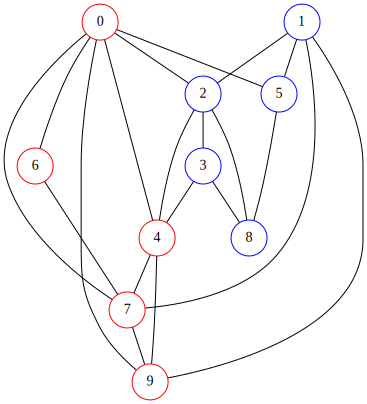

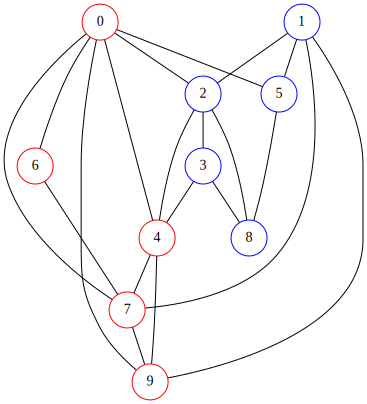

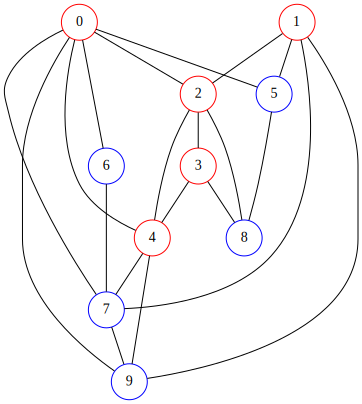

In [10]:
G = random_graph(10, [KLPart, bipartition, bipartition2])
from IPython.display import display
display(G[0], G[1], G[2])

In [22]:
class SimpleVertex:
    def __init__(self, name, area):
        self._name = name
        self._area = area

    def __repr__(self):
        return self._name + f" ({round(self._area,2)})"

def initialize_partition_gains(partition_a, partition_b, neighbor_lists, vertices):
    """Initialize partition assignments and calculate initial gains for each vertex."""
    partition_assignment = {v: 0 for v in vertices.keys()}
    stay_gain = {v: 0 for v in vertices.keys()}
    move_gain = {v: 0 for v in vertices.keys()}

    # Assign partition numbers (0 for A, 1 for B)
    for j, partition in enumerate((partition_a, partition_b)):
        for vertex in partition:
            partition_assignment[vertex._name] = j

    # Calculate initial gains for each vertex
    for vertex in vertices.values():
        vertex_partition = partition_assignment[vertex._name]
        for neighbor_list in neighbor_lists[vertex._name]:
            if len(neighbor_list) == 1:
                gain_type = move_gain if partition_assignment[neighbor_list[0]._name] == vertex_partition else stay_gain
                gain_type[vertex._name] += 1
            else:
                if all(partition_assignment[j._name] == vertex_partition for j in neighbor_list):
                    move_gain[vertex._name] += 1
                if all(partition_assignment[j._name] != vertex_partition for j in neighbor_list):
                    stay_gain[vertex._name] += 1

    return partition_assignment, stay_gain, move_gain

def find_max_gain_move(vertices, partition_a, partition_b, stay_gain, move_gain, min_area, max_area, num_edges):
    """Find vertex with maximum gain that maintains balance when moved."""
    max_gain = float('-inf')
    best_vertex = None

    # Calculate current areas
    area_a = sum(v._area for v in partition_a)
    area_b = sum(v._area for v in partition_b)

    # Check moves from A to B and B to A
    for partition, area, max_area, other_partition in (
        (partition_a, area_b, max_area, partition_b),
        (partition_b, area_a, max_area, partition_a),
    ):
        for vertex in partition:
            gain = stay_gain[vertex._name] - move_gain[vertex._name]
            new_area = area + vertex._area
            if new_area <= max_area and gain > max_gain:
                best_vertex = vertex
                max_gain = gain

    return best_vertex, max_gain

def update_gains(vertices, stay_gain, move_gain, moved_vertex, neighbor_lists, partition_assignment):
    """Update gains after moving a vertex."""
    vertex_part = partition_assignment[moved_vertex._name]

    for neighbor_list in neighbor_lists[moved_vertex._name]:
        if len(neighbor_list) == 1:
            neighbor = neighbor_list[0]
            if partition_assignment[neighbor._name] == vertex_part:
                stay_gain[neighbor._name] += 1
            else:
                move_gain[neighbor._name] += 1
        else:
            all_same = all(partition_assignment[n._name] == vertex_part for n in neighbor_list)
            any_same = any(partition_assignment[n._name] == vertex_part for n in neighbor_list)

            if all_same:
                for neighbor in neighbor_list:
                    move_gain[neighbor._name] += 1
            if not any_same:
                for neighbor in neighbor_list:
                    stay_gain[neighbor._name] += 1

    return stay_gain, move_gain

def partition_fm(vertices, edges, min_area, max_area):
    """Partition a hypergraph using Fiduccia-Mattheyses algorithm."""
    # Initialize data structures
    neighbor_lists = {v: [] for v in vertices.keys()}
    partition_assignment = {v: 0 for v in vertices.keys()}
    stay_gain = {v: 0 for v in vertices.keys()}
    move_gain = {v: 0 for v in vertices.keys()}
    cuts = 0
    moved_vertices = set()

    # Build neighbor lists for each vertex
    for edge in edges.values():
        for vertex in edge:
            neighbors = [v for v in edge if v != vertex]
            neighbor_lists[vertex._name].append(neighbors)

    # Initial partitioning
    partition_a, partition_b = [], []
    sum_a, sum_b = 0, 0

    # Fill to minimum area and distribute remaining vertices
    for vertex in vertices.values():
        if sum_a < min_area or (sum_a + vertex._area <= max_area and sum_b >= min_area):
            partition_a.append(vertex)
            sum_a += vertex._area
        elif sum_b < min_area or (sum_b + vertex._area <= max_area):
            partition_b.append(vertex)
            sum_b += vertex._area

    # Main FM algorithm loop
    maxGain = 1
    iteration_count = 0  # Initialize iteration counter
    while maxGain > 0:
        if iteration_count >= len(vertices):  # Break if iteration count exceeds number of vertices
            break

        Ap, Bp = partition_a.copy(), partition_b.copy()
        G, S = [], []
        moved_vertices.clear()

        # Reset gains and partitions
        partition_assignment, stay_gain, move_gain = initialize_partition_gains(
            partition_a, partition_b, neighbor_lists, vertices
        )

        # Move vertices until no more valid moves
        while len(S) <= len(vertices):
            res_vertex, g = find_max_gain_move(
                vertices, Ap, Bp,
                stay_gain, move_gain, min_area, max_area,
                len(edges.items())
            )

            if not res_vertex or res_vertex._name in moved_vertices:
                break

            # Update gains and move vertex
            stay_gain, move_gain = update_gains(
                vertices, stay_gain, move_gain,
                res_vertex, neighbor_lists, partition_assignment
            )
            (Ap if res_vertex in Ap else Bp).remove(res_vertex)
            (Bp if res_vertex in Ap else Ap).append(res_vertex)
            partition_assignment[res_vertex._name] = 1 if res_vertex in Bp else 0

            G.append(g)
            S.append(res_vertex)
            moved_vertices.add(res_vertex._name)

        # Calculate cumulative gains
        if G:
            # Find best sequence of moves using running sum
            maxGain, running_sum, maxIndex = 0, 0, -1
            for i, gain in enumerate(G):
                running_sum += gain
                if running_sum > maxGain:
                    maxGain = running_sum
                    maxIndex = i

            # Apply best sequence if improvement found
            if maxGain > 0:
                test_a, test_b = partition_a.copy(), partition_b.copy()
                for vertex in S[:maxIndex + 1]:
                    (test_a if vertex in test_a else test_b).remove(vertex)
                    (test_b if vertex in test_a else test_a).append(vertex)

                test_a_area = sum(v._area for v in test_a)
                test_b_area = sum(v._area for v in test_b)

                if min_area <= test_a_area <= max_area and min_area <= test_b_area <= max_area:
                    for vertex in S[:maxIndex + 1]:
                        (partition_a if vertex in partition_a else partition_b).remove(vertex)
                        (partition_b if vertex in partition_a else partition_a).append(vertex)
                        partition_assignment[vertex._name] = 1 if vertex in partition_b else 0
                else:
                    maxGain = 0
            else:
                break
        else:
            maxGain = 0
            break

        iteration_count += 1  # Increment iteration counter

    # Calculate final cut size
    final_cuts = 0
    for edge in edges.values():
        comp_part = partition_assignment[edge[0]._name]
        for item in edge[1:]:
            if partition_assignment[item._name] != comp_part:
                final_cuts += 1
                break

    return partition_a, partition_b, final_cuts

def FMPart(N, E):
    """Perform partitioning using the FM algorithm with N vertices and E edges."""
    # Create vertices with unit areas
    vertices = {f'v{i}': SimpleVertex(f'v{i}', 1) for i in range(N)}

    # Create edges dictionary
    edges = {f'e{i}': [vertices[f'v{u}'], vertices[f'v{v}']] for i, (u, v) in enumerate(E)}

    # Calculate total area and set constraints
    total_area = sum(v._area for v in vertices.values())
    min_area, max_area = total_area * 0.4, total_area * 0.6

    # Run FM partitioning
    A, B, cut_size = partition_fm(vertices, edges, min_area, max_area)

    # Reconstruct A and B from vertices
    A = {v._name[1:] for v in A}
    B = {v._name[1:] for v in B}

    # Return the partitions and cut size
    return A, B, cut_size

{2, 3, 4, 6, 7, 11}
{0, 1, 5, 8, 9, 10}
runtime :  0.0019795894622802734 cut size :  9
runtime :  0.6231412887573242 cut size :  9.0
runtime :  0.0006053447723388672 cut size :  11


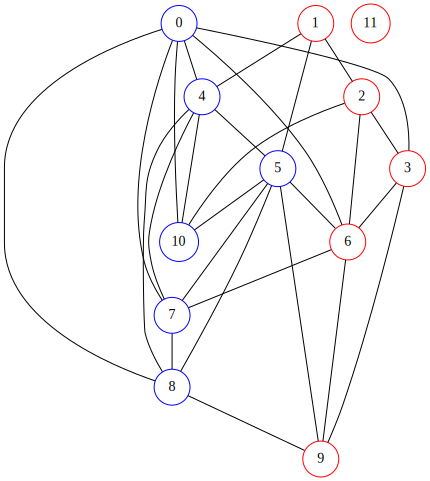

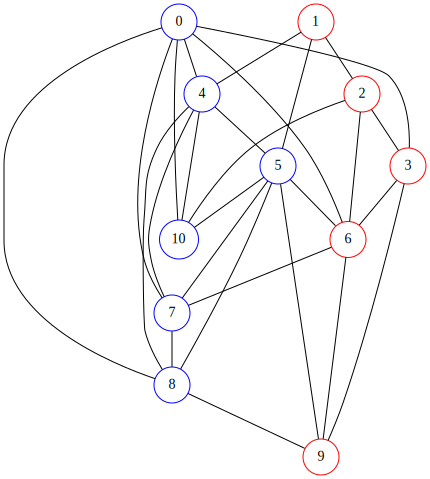

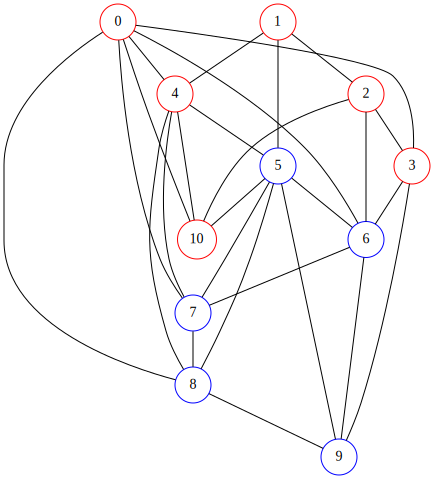

In [23]:
G = random_graph(11, [KLPart, bipartition, FMPart])
from IPython.display import display
display(G[0], G[1], G[2])


{0, 1, 3, 13, 14, 15, 19, 20, 21, 22, 24, 25, 26, 27, 28, 31, 34, 35, 37, 39}
{2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 23, 29, 30, 32, 33, 36, 38}
runtime :  0.010362386703491211 cut size :  108
runtime :  0.01062321662902832 cut size :  132


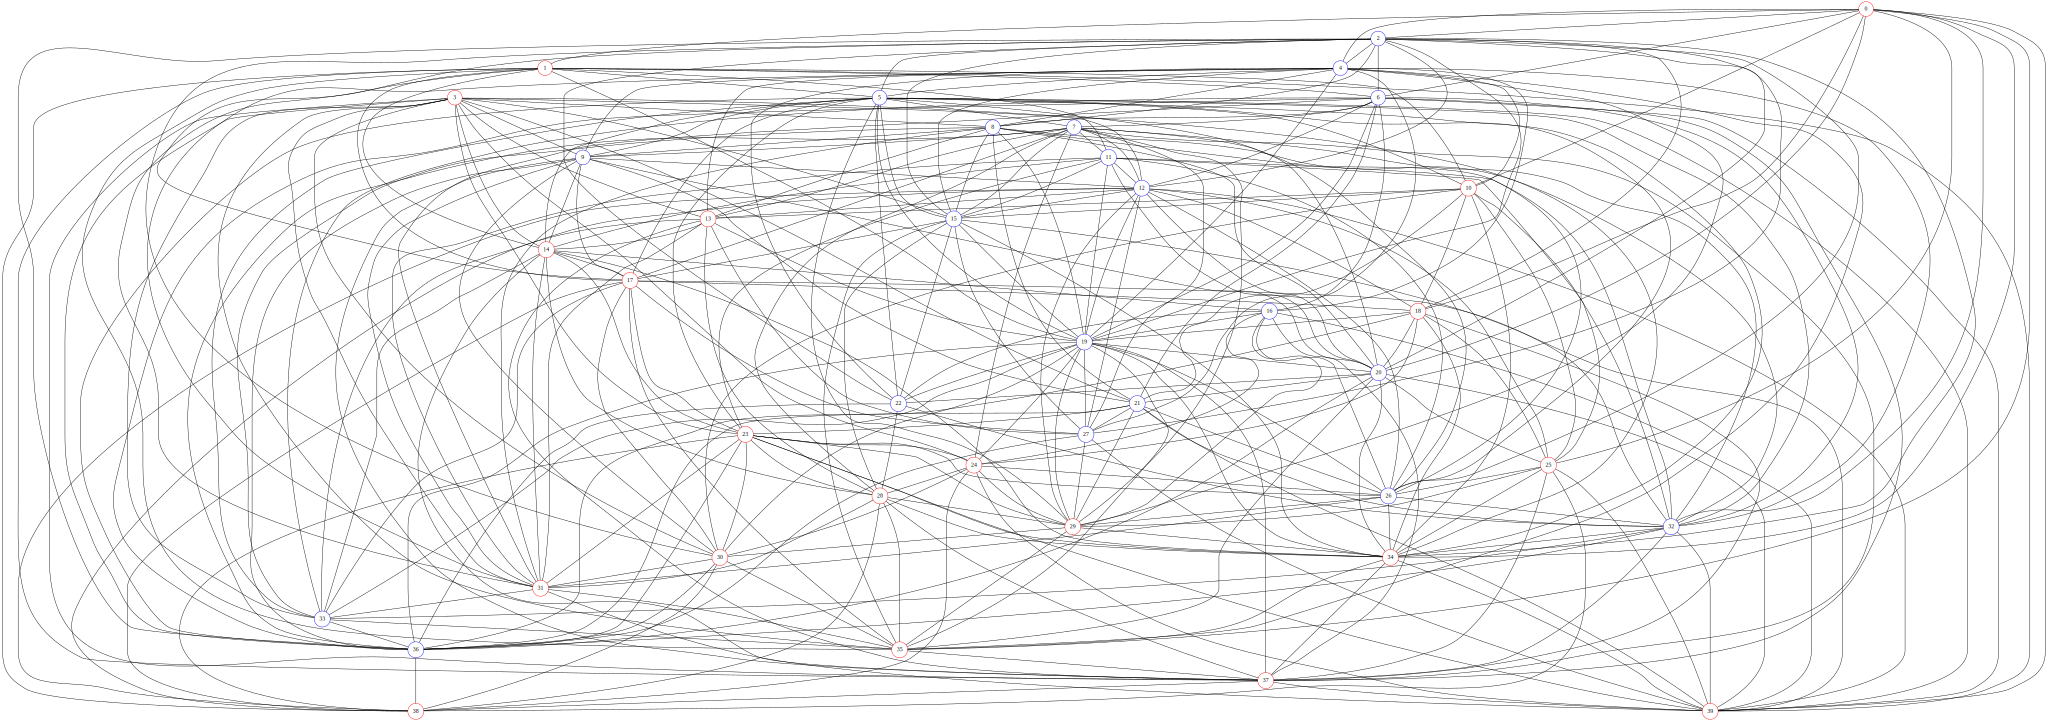

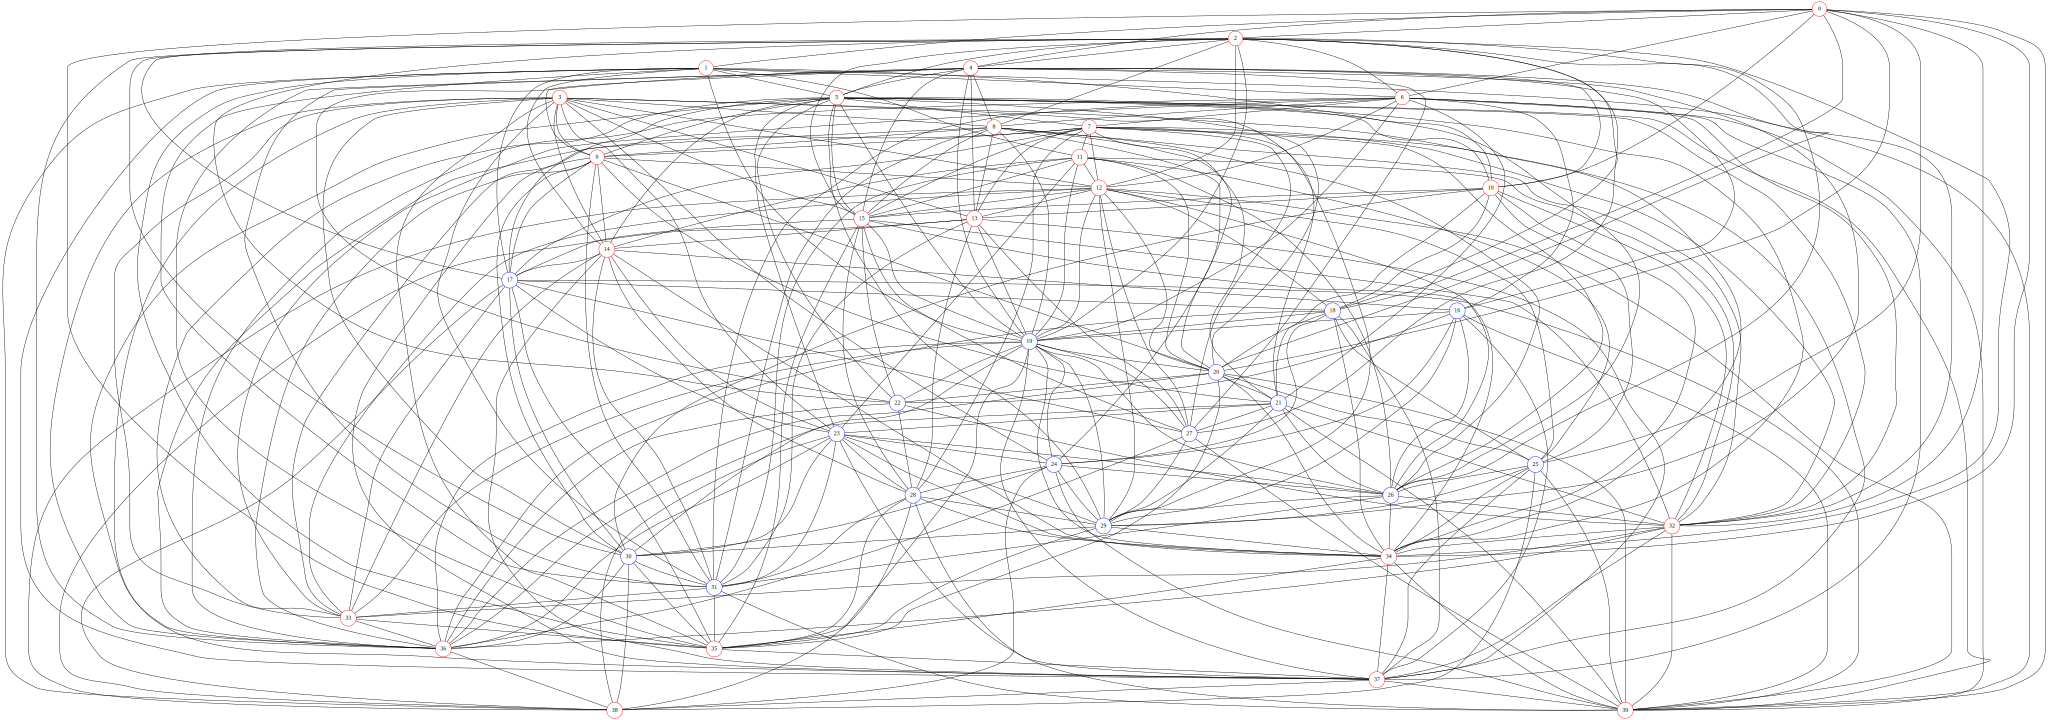

In [24]:
G = random_graph(40, [KLPart, FMPart])
from IPython.display import display
display(G[0], G[1])

## LEF DEF Parsing

- Install the LEFDEFParser from the the wheel file : [LEFDEFParser-0.1-cp310-cp310-linux_x86_64.whl](https://github.com/srini229/EE5333_tutorials/blob/master/parser/LEFDEFParser-0.1-cp310-cp310-linux_x86_64.whl)
- Download example LEF and DEF files: [Nangate.lef](https://github.com/srini229/EE5333_tutorials/blob/master/parser/Nangate.lef) and [example.def](https://github.com/srini229/EE5333_tutorials/blob/master/parser/example.def)

    <img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/part/fig/example_cir.png" width=340 height=195 />



In [30]:
!pip install --break-system-packages https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/LEFDEFParser-0.1-cp311-cp311-linux_x86_64.whl
!rm *.{lef,def}
!wget https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/{Nangate.lef,example.def}
!wget https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/sample.{lef,def}

  Using cached https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/LEFDEFParser-0.1-cp311-cp311-linux_x86_64.whl (617 kB)
--2025-02-14 17:17:29--  https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/Nangate.lef
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1083933 (1.0M) [text/plain]
Saving to: ‘Nangate.lef’

Nangate.lef         100%[===================>]   1.03M  --.-KB/s    in 0.06s   

2025-02-14 17:17:29 (17.2 MB/s) - ‘Nangate.lef’ saved [1083933/1083933]

--2025-02-14 17:17:29--  https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/example.def
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 899 [text/plain]
Saving to: ‘

In [54]:
def loadNetlist(leffile, deffile):
    import LEFDEFParser as LDP
    # [Assistant] Added error handling for when readLEF returns None
    lef_data = LDP.LEFReader().readLEF(leffile)
    if lef_data is None:
        raise ValueError(f"Error: Could not read or parse LEF file '{leffile}'. Please check if the file exists and is in the correct format.")
    areas = {m.name(): m.xdim() * m.ydim() * 1.e-6 for m in lef_data.macros()} if leffile else {}
    vertices, edges = {}, {}
    if deffile:
        d = LDP.DEFReader().readDEF(deffile)
        vertices = {c.name(): SimpleVertex(c.name(), areas.get(c.macro(), None)) for c in d.components()}
        edges = {n.name(): [vertices[p[0]] for p in n.pins() if p[0] != 'PIN'] for n in d.nets()}
    edges = {e: edges[e] for e in edges if len(edges[e]) > 1}
    return vertices, edges

In [55]:
V,E = loadNetlist('Nangate.lef', 'example.def')
Atotal = sum(V[u]._area for u in V)
maxCellArea = max(V[u]._area for u in V)
print(Atotal, round(maxCellArea,2))

ValueError: Error: Could not read or parse LEF file 'Nangate.lef'. Please check if the file exists and is in the correct format.

In [56]:
V,E = loadNetlist('sample.lef', 'sample.def')
Atotal = sum(V[u]._area for u in V)
maxCellArea = max(V[u]._area for u in V)
print(Atotal, round(maxCellArea,2))

ValueError: Error: Could not read or parse LEF file 'sample.lef'. Please check if the file exists and is in the correct format.